Running N-body Tensor Core Benchmark...
Running N-Body benchmark with memory limit: 3000 MB

GPU: Unknown GPU

=== Testing with 50,000 particles ===

Running CuPy implementation...
Could not determine total GPU memory. Using default value.
Memory configuration:
  Total GPU memory: 4096 MB
  Memory limit: 3000 MB
Optimized tile size: 512
Step 0/5...

Simulation complete (cupy):
  Particles: 50,000
  Tile size: 512
  Force calculation: 121.020s (100.0%)
  Total time: 121.022s
  Performance: 2.07 GFLOPS
  Memory usage: 0.0 MB / 0.0 MB

Running Tensor Core implementation...
Could not determine total GPU memory. Using default value.
Memory configuration:
  Total GPU memory: 4096 MB
  Memory limit: 3000 MB
Initializing CUDA...
CUDA initialization complete
Loading library: ./cuda_matlib.so
Function signatures configured
Initializing CUDA resources (one-time operation)...
CUDA resources initialized
Optimized tile size: 512
Step 0/5...

Simulation complete (tensor):
  Particles: 50,000
  Tile s

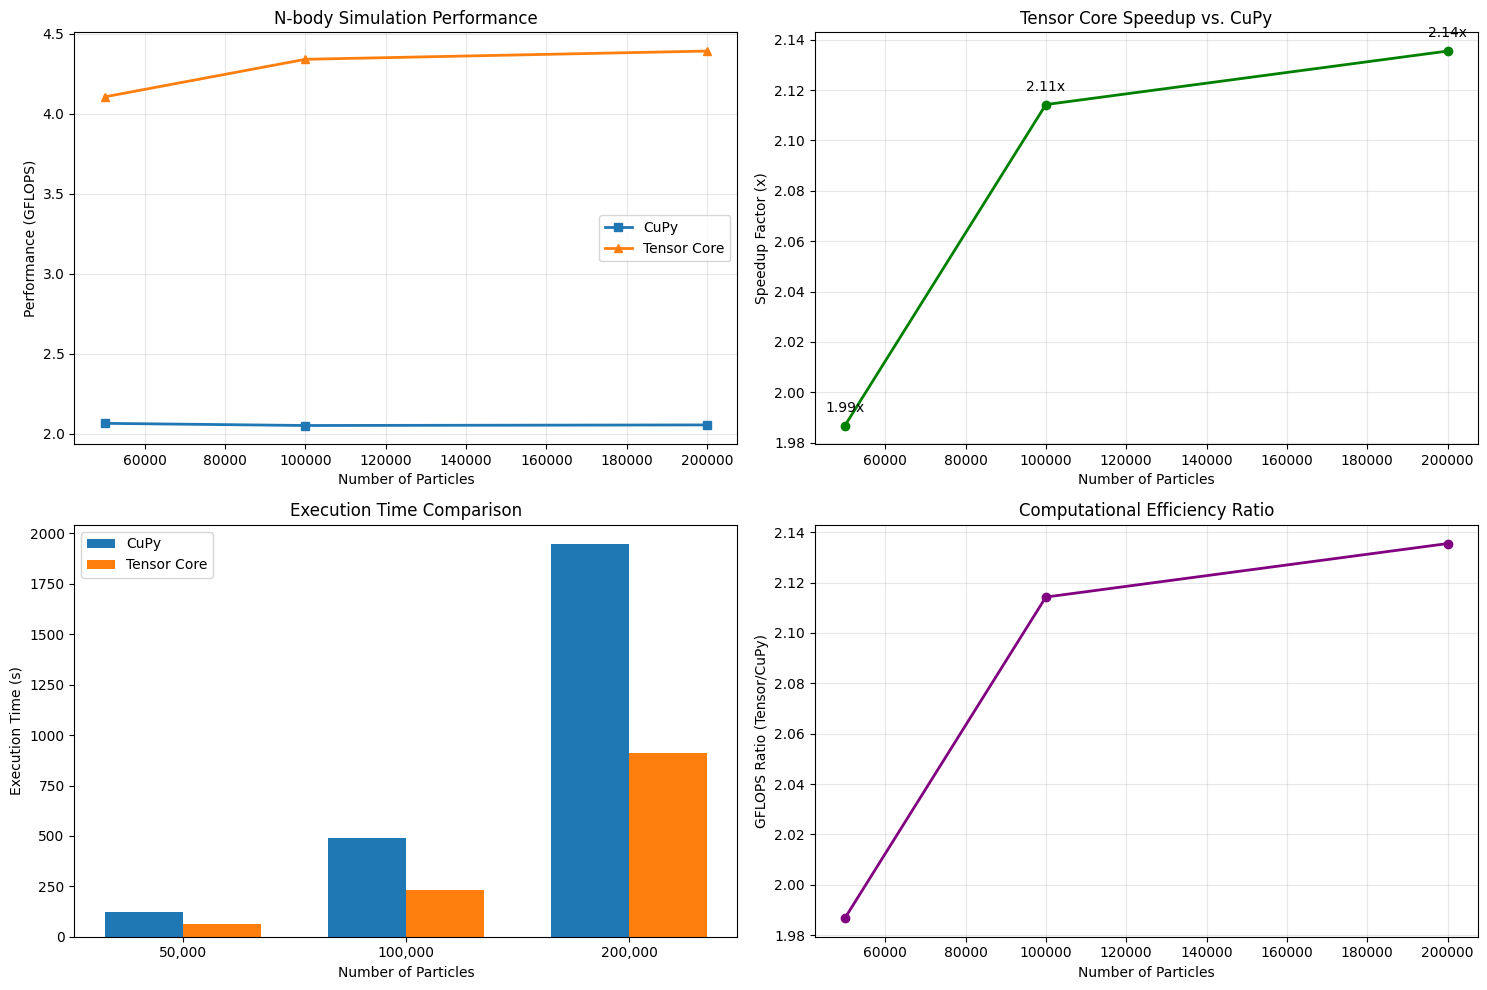

In [1]:
import numpy as np
import cupy as cp
import time
import matplotlib.pyplot as plt
from tensor_matrix_ops import TensorMatrixOps

class NBodySimulator:
    """Memory-optimized N-body simulation using tensor cores."""
    
    def __init__(self, backend='tensor', tile_size=512, memory_limit_mb=None):
        """
        Initialize N-body simulator with configurable memory settings.
        
        Args:
            backend: 'cupy' or 'tensor'
            tile_size: Size of tiles for processing
            memory_limit_mb: Memory limit in MB (None for automatic)
        """
        self.backend = backend
        self.tile_size = tile_size
        self.positions = None
        self.velocities = None
        self.masses = None
        self.forces = None
        self.num_particles = 0
        self.G = 1.0  # Gravitational constant
        self.softening = 1e-4  # Softening parameter
        
        # Configure memory settings
        self.configure_memory(memory_limit_mb)
        
        # Initialize tensor ops if needed
        if backend == 'tensor':
            self.tensor_ops = TensorMatrixOps()
        
        # Timing metrics
        self.force_time = 0
        self.total_time = 0
    
    def configure_memory(self, memory_limit_mb):
        """Configure GPU memory settings for optimal performance."""
        try:
            # Try to get GPU memory information
            device = cp.cuda.Device(0)
            
            # Get device attributes safely
            device_props = device.attributes
            
            # Try different attribute names for total memory
            if "TotalGlobalMem" in device_props:
                total_memory = device_props["TotalGlobalMem"]
            elif "total_global_memory" in device_props:
                total_memory = device_props["total_global_memory"]
            else:
                # Estimate based on common GPU sizes
                print("Could not determine total GPU memory. Using default value.")
                total_memory = 4 * 1024**3  # Assume 4GB
            
            total_memory_mb = total_memory / (1024**2)
            
            print(f"Memory configuration:")
            print(f"  Total GPU memory: {total_memory_mb:.0f} MB")
            
            # Set memory pool limit
            if memory_limit_mb is None:
                # Use 80% of available memory by default
                memory_limit_mb = int(total_memory_mb * 0.8)
            
            print(f"  Memory limit: {memory_limit_mb:.0f} MB")
            
            # Configure memory pool
            cp.cuda.set_allocator(cp.cuda.MemoryPool().malloc)
            pool = cp.get_default_memory_pool()
            pool.set_limit(size=memory_limit_mb * 1024**2)
            
        except Exception as e:
            print(f"Warning: Could not configure GPU memory: {e}")
            print("Running with default memory settings")
            
            # Try to set memory pool anyway
            if memory_limit_mb is not None:
                try:
                    cp.cuda.set_allocator(cp.cuda.MemoryPool().malloc)
                    pool = cp.get_default_memory_pool()
                    pool.set_limit(size=memory_limit_mb * 1024**2)
                    print(f"Set memory limit to {memory_limit_mb} MB")
                except Exception as e2:
                    print(f"Could not set memory limit: {e2}")
    
    def optimize_tile_size(self, num_particles):
        """Dynamically optimize tile size based on particle count."""
        # Base tile size on particle count
        if num_particles < 10_000:
            return min(self.tile_size, 512)
        elif num_particles < 40_000:
            return min(self.tile_size, 1026)
        else:
            return min(self.tile_size, 2048)
    
    def init_random(self, num_particles, seed=42):
        """Initialize random particles."""
        np.random.seed(seed)
        self.num_particles = num_particles
        
        # Generate random positions and zero velocities
        self.positions = np.random.normal(0, 1, (num_particles, 3)).astype(np.float64)
        self.velocities = np.zeros((num_particles, 3), dtype=np.float64)
        self.masses = np.ones(num_particles, dtype=np.float64)
        self.forces = np.zeros((num_particles, 3), dtype=np.float64)
        
        # Normalize positions
        max_pos = np.max(np.abs(self.positions))
        self.positions /= max_pos
        
        # Move to GPU
        self.positions = cp.array(self.positions)
        self.velocities = cp.array(self.velocities)
        self.masses = cp.array(self.masses)
        self.forces = cp.array(self.forces)
        
        # Optimize tile size based on particle count
        self.tile_size = self.optimize_tile_size(num_particles)
        print(f"Optimized tile size: {self.tile_size}")
    
    def calculate_forces_cupy(self):
        """Calculate forces using optimized CuPy implementation."""
        # Reset forces
        self.forces.fill(0)
        
        # Use optimized tile size
        tile_size = self.tile_size
        
        # For smaller systems, use a simpler approach
        for i in range(0, self.num_particles, tile_size):
            i_end = min(i + tile_size, self.num_particles)
            i_count = i_end - i
            
            # Position data for tile i
            pos_i = self.positions[i:i_end]
            mass_i = self.masses[i:i_end]
            
            # Pre-allocate force accumulation array
            force_accumulator = cp.zeros((i_count, 3), dtype=cp.float64)
            
            for j in range(0, self.num_particles, tile_size):
                j_end = min(j + tile_size, self.num_particles)
                j_count = j_end - j
                
                # Position data for tile j
                pos_j = self.positions[j:j_end]
                mass_j = self.masses[j:j_end]
                
                # Process each dimension separately to avoid broadcasting issues
                dx = pos_j[:, 0].reshape(1, j_count) - pos_i[:, 0].reshape(i_count, 1)
                dy = pos_j[:, 1].reshape(1, j_count) - pos_i[:, 1].reshape(i_count, 1)
                dz = pos_j[:, 2].reshape(1, j_count) - pos_i[:, 2].reshape(i_count, 1)
                
                # Distance squared
                r_squared = dx**2 + dy**2 + dz**2 + self.softening**2
                
                # Handle self-interaction
                if i == j:
                    for k in range(min(i_count, j_count)):
                        r_squared[k, k] = float('inf')
                
                # Calculate inverse cube root for force scaling
                inv_r_cubed = cp.power(r_squared, -1.5)
                
                # Calculate mass product term
                mass_term = self.G * mass_i.reshape(i_count, 1) * mass_j.reshape(1, j_count)
                
                # Apply force calculation to each component
                force_accumulator[:, 0] += cp.sum(mass_term * inv_r_cubed * dx, axis=1)
                force_accumulator[:, 1] += cp.sum(mass_term * inv_r_cubed * dy, axis=1)
                force_accumulator[:, 2] += cp.sum(mass_term * inv_r_cubed * dz, axis=1)
            
            # Accumulate forces for this batch
            self.forces[i:i_end] = force_accumulator
    
    def calculate_forces_tensor(self):
        """Calculate forces using tensor core implementation."""
        # Reset forces
        self.forces.fill(0)
        
        # Use optimized tile size
        tile_size = self.tile_size
        
        # Process in tiles
        for i_start in range(0, self.num_particles, tile_size):
            i_end = min(i_start + tile_size, self.num_particles)
            i_count = i_end - i_start
            
            # Position data for tile i
            pos_i = self.positions[i_start:i_end]  # Shape: (i_count, 3)
            mass_i = self.masses[i_start:i_end]    # Shape: (i_count)
            
            # Precompute squared magnitudes for particle set i
            pos_i_sq = cp.sum(pos_i**2, axis=1)  # Shape: (i_count)
            
            # Initialize forces for this batch
            forces_batch = cp.zeros((i_count, 3), dtype=cp.float64)
            
            for j_start in range(0, self.num_particles, tile_size):
                j_end = min(j_start + tile_size, self.num_particles)
                j_count = j_end - j_start
                
                # Position data for tile j
                pos_j = self.positions[j_start:j_end]  # Shape: (j_count, 3)
                mass_j = self.masses[j_start:j_end]    # Shape: (j_count)
                
                # Precompute squared magnitudes for particle set j
                pos_j_sq = cp.sum(pos_j**2, axis=1)  # Shape: (j_count)
                
                # KEY TENSOR CORE USAGE: Matrix multiplication for position dot products
                # This is the operation that leverages tensor cores
                dot_products = self.tensor_ops.matmul(pos_i, pos_j.T)  # Shape: (i_count, j_count)
                
                # Complete distance calculation: ||r_i - r_j||² = ||r_i||² + ||r_j||² - 2(r_i·r_j)
                r_squared = pos_i_sq.reshape(i_count, 1) + pos_j_sq.reshape(1, j_count) - 2 * dot_products
                r_squared += self.softening**2
                
                # Handle self-interactions
                if i_start <= j_start < i_end or j_start <= i_start < j_end:
                    for ii in range(i_count):
                        for jj in range(j_count):
                            if i_start + ii == j_start + jj:
                                r_squared[ii, jj] = float('inf')
                
                # Calculate inverse cube root for force scaling
                inv_r_cubed = cp.power(r_squared, -1.5)
                
                # Calculate mass product term
                mass_term = self.G * mass_i.reshape(i_count, 1) * mass_j.reshape(1, j_count)
                
                # OPTIMIZATION: Calculate forces for each dimension at once
                for dim in range(3):
                    # Compute direction vectors for this dimension
                    dr_dim = pos_j[:, dim].reshape(1, j_count) - pos_i[:, dim].reshape(i_count, 1)
                    
                    # Force contribution
                    force_contrib = dr_dim * mass_term * inv_r_cubed
                    forces_batch[:, dim] += cp.sum(force_contrib, axis=1)
            
            # Add to global forces array
            self.forces[i_start:i_end] += forces_batch
    
    def calculate_forces(self):
        """Calculate forces using the selected backend."""
        start_time = time.time()
        
        if self.backend == 'cupy':
            self.calculate_forces_cupy()
        elif self.backend == 'tensor':
            self.calculate_forces_tensor()
        
        # Synchronize
        cp.cuda.runtime.deviceSynchronize()
            
        self.force_time += time.time() - start_time
    
    def integrate(self, dt):
        """Leapfrog integration."""
        # Update velocities (half step)
        self.velocities += 0.5 * dt * self.forces / self.masses[:, None]
        
        # Update positions (full step)
        self.positions += dt * self.velocities
        
        # Recalculate forces
        self.calculate_forces()
        
        # Update velocities (half step)
        self.velocities += 0.5 * dt * self.forces / self.masses[:, None]
    
    def run(self, steps, dt=0.01):
        """Run simulation for given number of steps."""
        self.force_time = 0
        start_time = time.time()
        
        # Calculate initial forces
        self.calculate_forces()
        
        # Run integration steps
        for step in range(steps):
            if step % 5 == 0:
                print(f"Step {step}/{steps}...")
            
            self.integrate(dt)
        
        # Complete timing
        self.total_time = time.time() - start_time
        
        # Get memory usage stats
        try:
            memory_pool = cp.get_default_memory_pool()
            used_bytes = memory_pool.used_bytes()
            total_bytes = memory_pool.total_bytes()
        except:
            used_bytes = 0
            total_bytes = 0
        
        # Calculate GFLOPS
        ops_per_step = self.num_particles**2 * 20  # ~20 ops per particle pair
        total_ops = ops_per_step * steps
        gflops = total_ops / self.force_time / 1e9
        
        print(f"\nSimulation complete ({self.backend}):")
        print(f"  Particles: {self.num_particles:,}")
        print(f"  Tile size: {self.tile_size:,}")
        print(f"  Force calculation: {self.force_time:.3f}s ({self.force_time/self.total_time:.1%})")
        print(f"  Total time: {self.total_time:.3f}s")
        print(f"  Performance: {gflops:.2f} GFLOPS")
        print(f"  Memory usage: {used_bytes/(1024**2):.1f} MB / {total_bytes/(1024**2):.1f} MB")
        
        return {
            'time': self.total_time,
            'force_time': self.force_time,
            'gflops': gflops,
            'memory_used': used_bytes,
            'memory_total': total_bytes
        }

def run_benchmark(particle_counts=[1_000, 10_000, 100_000], steps=5, memory_limit_mb=4000):
    """Run benchmark comparing CuPy and Tensor Core implementations."""
    results = {'cupy': {}, 'tensor': {}}
    
    print(f"Running N-Body benchmark with memory limit: {memory_limit_mb} MB")
    
    # Try to get GPU info
    try:
        device = cp.cuda.Device(0)
        gpu_name = device.attributes.get("name", "Unknown GPU")
        print(f"\nGPU: {gpu_name}")
    except:
        print("\nUnable to query GPU information")
    
    for count in particle_counts:
        print(f"\n=== Testing with {count:,} particles ===")
        
        # Create CuPy simulator
        print("\nRunning CuPy implementation...")
        cupy_sim = NBodySimulator(backend='cupy', memory_limit_mb=memory_limit_mb)
        cupy_sim.init_random(count)
        results['cupy'][count] = cupy_sim.run(steps)
        
        # Free memory
        del cupy_sim
        cp.get_default_memory_pool().free_all_blocks()
        
        # Create tensor simulator
        print("\nRunning Tensor Core implementation...")
        tensor_sim = NBodySimulator(backend='tensor', memory_limit_mb=memory_limit_mb)
        tensor_sim.init_random(count)
        results['tensor'][count] = tensor_sim.run(steps)
        
        # Print speedup
        cupy_time = results['cupy'][count]['force_time']
        tensor_time = results['tensor'][count]['force_time']
        cupy_gflops = results['cupy'][count]['gflops']
        tensor_gflops = results['tensor'][count]['gflops']
        
        print(f"\nComparison:")
        print(f"  CuPy: {cupy_time:.3f}s @ {cupy_gflops:.2f} GFLOPS")
        print(f"  Tensor: {tensor_time:.3f}s @ {tensor_gflops:.2f} GFLOPS")
        print(f"  Speedup: {cupy_time/tensor_time:.2f}x")
        
        # Free memory
        del tensor_sim
        cp.get_default_memory_pool().free_all_blocks()
    
    return results

def plot_results(results):
    """Plot performance comparison results."""
    plt.figure(figsize=(15, 10))
    
    # Extract data
    particle_counts = sorted(list(results['cupy'].keys()))
    
    # Performance comparison (GFLOPS)
    plt.subplot(2, 2, 1)
    
    # Collect data points
    cupy_gflops = [results['cupy'][count]['gflops'] for count in particle_counts]
    tensor_gflops = [results['tensor'][count]['gflops'] for count in particle_counts]
    
    # Plot performance
    plt.plot(particle_counts, cupy_gflops, 's-', label='CuPy', linewidth=2)
    plt.plot(particle_counts, tensor_gflops, '^-', label='Tensor Core', linewidth=2)
    
    plt.xlabel('Number of Particles')
    plt.ylabel('Performance (GFLOPS)')
    plt.title('N-body Simulation Performance')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # Speedup
    plt.subplot(2, 2, 2)
    speedups = [results['cupy'][count]['force_time']/results['tensor'][count]['force_time'] 
                for count in particle_counts]
    plt.plot(particle_counts, speedups, 'o-', color='green', linewidth=2)
    
    plt.xlabel('Number of Particles')
    plt.ylabel('Speedup Factor (x)')
    plt.title('Tensor Core Speedup vs. CuPy')
    plt.grid(True, alpha=0.3)
    
    # Annotate speedups
    for i, count in enumerate(particle_counts):
        plt.annotate(f"{speedups[i]:.2f}x", 
                     (count, speedups[i]),
                     textcoords="offset points", 
                     xytext=(0,10),
                     ha='center')
    
    # Execution times
    plt.subplot(2, 2, 3)
    cupy_time = [results['cupy'][count]['force_time'] for count in particle_counts]
    tensor_time = [results['tensor'][count]['force_time'] for count in particle_counts]
    
    bar_width = 0.35
    idx = np.arange(len(particle_counts))
    
    plt.bar(idx - bar_width/2, cupy_time, bar_width, label='CuPy')
    plt.bar(idx + bar_width/2, tensor_time, bar_width, label='Tensor Core')
    
    plt.xlabel('Number of Particles')
    plt.ylabel('Execution Time (s)')
    plt.title('Execution Time Comparison')
    plt.xticks(idx, [f"{count:,}" for count in particle_counts])
    plt.legend()
    
    # GFLOPS ratio
    plt.subplot(2, 2, 4)
    gflops_ratio = [tensor_gflops[i]/cupy_gflops[i] for i in range(len(particle_counts))]
    
    plt.plot(particle_counts, gflops_ratio, 'o-', color='purple', linewidth=2)
    
    plt.xlabel('Number of Particles')
    plt.ylabel('GFLOPS Ratio (Tensor/CuPy)')
    plt.title('Computational Efficiency Ratio')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('nbody_tensor_benchmark.png', dpi=300)
    plt.show()

# For Jupyter - Run this directly
def run_jupyter_benchmark(memory_limit_mb=4000, particle_counts=None, steps=5):
    """Wrapper function for running the benchmark in Jupyter."""
    if particle_counts is None:
        particle_counts = [1000, 10000, 50000]
        
    print("Running N-body Tensor Core Benchmark...")
    results = run_benchmark(particle_counts, steps, memory_limit_mb)
    plot_results(results)
    return results

# Example notebook cell:
# results = run_jupyter_benchmark(memory_limit_mb=3000, particle_counts=[1000, 10000, 50000], steps=5)
results = run_jupyter_benchmark(memory_limit_mb=3000, particle_counts=[50000, 100_000, 200_000], steps=5)